In [2]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet
from torch.distributions.multivariate_normal import MultivariateNormal

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx, ry = xx.diag().unsqueeze(0).expand_as(xx), yy.diag().unsqueeze(0).expand_as(yy)
    dxx = rx.t() + rx - 2. * xx 
    dyy = ry.t() + ry - 2. * yy
    dxy = rx.t() + ry - 2. * zz

    XX, YY, XY = torch.zeros(xx.shape).to(device), torch.zeros(xx.shape).to(device), torch.zeros(xx.shape).to(device)
    if kernel == 'multiscale':
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * ((a**2 + dxx) ** (-1))
            YY += a**2 * ((a**2 + dyy) ** (-1))
            XY += a**2 * ((a**2 + dxy) ** (-1))

    if kernel == 'rbf':
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)

    return torch.mean(XX + YY - 2. * XY)


Code practice

<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:55: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:55: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_97993/503158625.py:47: SyntaxWarning: invalid escape sequence '\s'
  ax1.set_title("Distribution of $X \sim P(X)$")
/tmp/ipykernel_97993/503158625.py:55: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_title("Distribution of $Y \sim Q(Y)$")


MMD result of X and Y is 0.6601795554161072


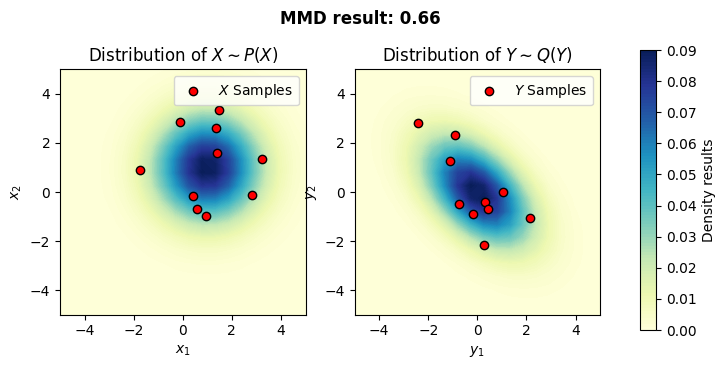

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet 
from torch.distributions.multivariate_normal import MultivariateNormal 


m = 20 # sample size
x_mean = torch.zeros(2)+1
y_mean = torch.zeros(2)
x_cov = 2*torch.eye(2) # IMPORTANT: Covariance matrices must be positive definite
y_cov = 3*torch.eye(2) - 1

px = MultivariateNormal(x_mean, x_cov)
qy = MultivariateNormal(y_mean, y_cov)
x = px.sample([m]).to(device)
y = qy.sample([m]).to(device)

result = MMD(x, y, kernel="multiscale")

print(f"MMD result of X and Y is {result.item()}")

# ---- Plotting setup ----

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), dpi=100)
#plt.tight_layout() 
delta = 0.025

x1_val = np.linspace(-5, 5, num=m)
x2_val = np.linspace(-5, 5, num=m)

x1, x2 = np.meshgrid(x1_val, x2_val)

px_grid = torch.zeros(m,m)
qy_grid = torch.zeros(m,m)


for i in range(m):
    for j in range(m):
        px_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], x_mean, x_cov)
        qy_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], y_mean, y_cov)


CS1 = ax1.contourf(x1, x2, px_grid,100, cmap=plt.cm.YlGnBu)
ax1.set_title("Distribution of $X \sim P(X)$")
ax1.set_ylabel('$x_2$')
ax1.set_xlabel('$x_1$')
ax1.set_aspect('equal')
ax1.scatter(x[:10,0].cpu(), x[:10,1].cpu(), label="$X$ Samples", marker="o", facecolor="r", edgecolor="k")
ax1.legend()

CS2 = ax2.contourf(x1, x2, qy_grid,100, cmap=plt.cm.YlGnBu)
ax2.set_title("Distribution of $Y \sim Q(Y)$")
ax2.set_xlabel('$y_1$')
ax2.set_ylabel('$y_2$')
ax2.set_aspect('equal')
ax2.scatter(y[:10,0].cpu(), y[:10,1].cpu(), label="$Y$ Samples", marker="o", facecolor="r", edgecolor="k")
ax2.legend()
#ax1.axis([-2.5, 2.5, -2.5, 2.5])

# Add colorbar and title
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(CS2, cax=cbar_ax)
cbar.ax.set_ylabel('Density results')
plt.suptitle(f"MMD result: {round(result.item(),3)}",y=0.95, fontweight="bold")
plt.show()

In [6]:
a = torch.arange(16).reshape(4, 4)
b = a.pow(2).sum(1, keepdim=True)

In [7]:
b

tensor([[ 14],
        [126],
        [366],
        [734]])

In [8]:
b.t()

tensor([[ 14, 126, 366, 734]])

In [9]:
b + b.t()

tensor([[  28,  140,  380,  748],
        [ 140,  252,  492,  860],
        [ 380,  492,  732, 1100],
        [ 748,  860, 1100, 1468]])

In [16]:
def imq_kernel(X: torch.Tensor,
               Y: torch.Tensor,
               h_dim: int):
    batch_size = X.size(0)

    norms_x = X.pow(2).sum(1, keepdim=True) # [batch_size, 1]
    prods_x = torch.mm(X, X.t()) # [batch_size, batch_size]
    dists_x = norms_x + norms_x.t() - 2 * prods_x

    norms_y = Y.pow(2).sum(1, keepdim=True) # [batch_size, 1]
    prods_y = torch.mm(Y, Y.t()) # [batch_size, batch_size]
    dists_y = norms_y + norms_y.t() - 2 * prods_y

    dot_prd = torch.mm(X, Y.t()) # [batch_size, batch_size]
    dists_c = norms_x + norms_y.t() - 2 * dot_prd # cross distances

    stats = 0
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = 2 * h_dim * 1.0 * scale
        res1  = C / (C + dists_x)
        res1 += C / (C + dists_y)

        if torch.cuda.is_available():
            res1 = (1 - torch.eye(batch_size).cuda()) * res1
        else: 
            res1 = (1 - torch.eye(batch_size)) * res1

        res1 = res1.sum() / (batch_size - 1)
        res2 = C / (C + dists_c)
        res2 = res2.sum() * 2. / batch_size
        stats += (res1 - res2)

    return stats


In [11]:
torch.eye(3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [12]:
2 / torch.eye(3)

tensor([[2., inf, inf],
        [inf, 2., inf],
        [inf, inf, 2.]])

In [13]:
import torch
import numpy as np
import random

In [17]:
# ======= TEST CASE =======

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seed
torch.manual_seed(0)
np.random.seed(0)

# Số mẫu và chiều không gian
batch_size = 2
h_dim = 2

# P(X) ~ N(0, I)
X = torch.randn(batch_size, h_dim).to(device)

# Q(Y) ~ N(0, I)
Y = torch.randn(batch_size, h_dim).to(device)

# Tính MMD bằng IMQ kernel
mmd_val = imq_kernel(X, Y, h_dim)

print("IMQ MMD:", round(mmd_val.item(), 4))

IMQ MMD: -3.0164
